In [24]:
import netCDF4
import pandas as pd
import numpy as np
from tyler_library.convert_calendar_decimal import convert_calendar_decimal
from tyler_library.tsregress import tsregress
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
def mapping2(tmp,lon,lat,levels,label,cmap,labelformat = '%2.1f',extend='max', set_bad='white'):
    fig = plt.figure(figsize=(20, 16),dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree(),ylim=(-60,90)) 
    ax.coastlines(color='black')
    norm = mpl.colors.BoundaryNorm(boundaries=levels,ncolors=256)
    img = ax.pcolormesh(lon, lat, tmp,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,shading='nearest')
    img.cmap.set_bad(set_bad)
    img.cmap.set_under('lightgrey')
    cbar=plt.colorbar(img,ax=ax,location='bottom',format=labelformat,extend=extend,pad=0.02,ticks=levels)#,ticks=mticker.MultipleLocator(50))
    cbar.ax.tick_params(labelsize=25,which='both')
    cbar.set_label(label=label,fontsize=25)  
    
    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
    #ax.set_extent([-124.67, -66.95, 25.84, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature(\
        'physical', 'land', scale="110m",\
        edgecolor='gray', facecolor='none'))
    #ax.add_feature(cfeature.NaturalEarthFeature(\
    #    'cultural', 'admin_1_states_provinces_lines', scale="50m",\
    #    edgecolor='gray', facecolor='none'))

In [17]:
### read in GRACE/FO data
dataset = netCDF4.Dataset('/Users/mzhao4/data.dir/HandsOnWorkshop/GRCTellus.JPL.200204_202305.GLO.RL06.1M.MSCNv03CRI.nc')
tmp_lat = dataset.variables['lat'][:]
tmp_lon = dataset.variables['lon'][:]
tmp_TWS = dataset.variables['lwe_thickness'][:] * 10 ## convert to mm
var_lat = np.flip(tmp_lat)
var_lon = tmp_lon - 180.
var_TWS = np.roll(np.flip(tmp_TWS,axis=1),360, axis=2)
var_TWS = var_TWS - np.mean(var_TWS,axis=0) 
err_TWS = dataset.variables['uncertainty'][:] * 10
err_TWS = np.roll(np.flip(err_TWS,axis=1),360, axis=2)

mascon_ID = dataset.variables['mascon_ID'][:].data
mascon_ID = np.roll(np.flip(mascon_ID,axis=0),360,axis=1)

date = pd.to_datetime(dataset.variables['time'][:],unit='D',origin=pd.Timestamp('2002-1-1'))
dtime = np.array([convert_calendar_decimal(i.year,i.month,i.day)[0] for i in date])


### read in temperature data
t2mdata = netCDF4.Dataset('/Users/mzhao4/data.dir/ERA5/t2m_1950_2022_ERA5.nc')['z'][-360:].data
t2mdata = np.roll(t2mdata,360,axis=2)

### read in runoff data
tst = netCDF4.Dataset('/Users/mzhao4/data.dir/Discharge_ET_project/discharge/G-RUN_ENSEMBLE_MMM.nc')
rtime = tst.variables['time'][:]
rtime = pd.to_datetime(rtime, unit='D',
               origin=pd.Timestamp('1901-07-01'))[-18*12:]
roff = np.flip(tst.variables['Runoff'][:].data[-18*12:,:,:],axis=1)
roff[roff==-9999.] = np.nan

### read in land cover data
lc_dataset = netCDF4.Dataset('/Users/mzhao4/data.dir/MODIS.dir/MCD12C1/IBGP_lc_qdeg.nc')
lcdata = lc_dataset.variables['z'][1::2,1::2]
landmask = (lcdata!=0)&(lcdata<15)#(lcdata!=15)
landmask = landmask.data.astype('int')


### This is set to account for different areal extent for each grid cell.
area_weights = np.zeros((len(var_lat),len(var_lon))) 
radius = 6371 # km
dlat, dlon = 0.5, 0.5 # each grid cell size is 0.5 degree on the latitude and longitude directions.  
for i in range(len(var_lat)):
    for j in range(len(var_lon)):
        area_weights[i,j] = radius**2*np.cos(np.radians(var_lat[i]))*np.radians(dlat)*np.radians(dlon) #dS = r²
        

### read in precipitation data
pdataset = []
pdate = pd.date_range('1993-1-1', '2022-12-1',freq='MS')
cnt = 0
for year in range(1993, 2023):
    for mon in range(1,13):
        fname = '/Users/mzhao4/data.dir/GPCP.dir/V3.2/GPCPMON_L3_{0:04d}{1:02d}_V3.2.nc4'.format(year,mon)
        if os.path.isfile(fname):
            test = netCDF4.Dataset(fname)['sat_gauge_precip'][0,:].data * pdate.days_in_month[cnt]
            pdataset.append(test)
            cnt = cnt+1
pdataset = np.array(pdataset)

/var/folders/gw/cdt200ld29vc4j0jf0gzty340000gn/T/ipykernel_60808/516391236.py:13: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  mascon_ID = dataset.variables['mascon_ID'][:].data
/var/folders/gw/cdt200ld29vc4j0jf0gzty340000gn/T/ipykernel_60808/516391236.py:13: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  mascon_ID = dataset.variables['mascon_ID'][:].data


In [19]:
### calculate root zone water storage from GRACE/GRACE-FO 
dtwsmaxarr = np.zeros((5,360,720))*np.nan
dtwsmaxtime = np.zeros((5,360,720))*np.nan
drawdownPminusR = np.zeros((5,360,720))*np.nan
GRACE_trend = np.zeros((360,720))*np.nan
overall_err = np.zeros((5,360,720))*np.nan

for mid in range(1,4552):
    msk = (mascon_ID==mid)&(landmask==1)
    if (np.sum(msk)>np.sum(mascon_ID==mid)*0.5):
        
        testmod2 = tsregress(dtime,np.mean(var_TWS[:,msk],axis=1),FIT_TYPE=3)
        GRACE_trend[mascon_ID == mid] = testmod2['beta'][1]
        if testmod2['beta'][1]<0:
            mascon_average_TWS = testmod2['model']-testmod2['simple']+testmod2['residual']
            groundwater_err = testmod2['beta'][1]
        else:
            mascon_average_TWS = testmod2['model']+testmod2['simple']+testmod2['residual']
            groundwater_err = 0
            
        mascon_average_TWS = pd.Series(mascon_average_TWS,index=date)
        mascon_average_TWS = mascon_average_TWS.resample('MS').mean().interpolate('linear',limit=2,limit_area='inside')
        mascon_average_TWS[pd.date_range('2017-7-1','2018-5-1',freq='MS')] = np.nan
        mascon_average_TWS = mascon_average_TWS[mascon_average_TWS.index.year<2023]
        
        mascon_average_TWS_err = pd.Series(np.mean(err_TWS[:,msk]),index=date)
        mascon_average_TWS_err = mascon_average_TWS_err.resample('MS').mean().interpolate('linear',limit=2,limit_area='inside')
        mascon_average_TWS_err[pd.date_range('2017-7-1','2018-5-1',freq='MS')] = np.nan
        mascon_average_TWS_err = mascon_average_TWS_err[mascon_average_TWS_err.index.year<2023]
        
        mascon_average_T2M = np.sum(t2mdata[:,msk]*np.tile(area_weights[msk],(t2mdata.shape[0],1)),axis=1)/\
        np.sum(np.tile(area_weights[msk],(t2mdata.shape[0],1)),axis=1)
        mascon_average_T2M = pd.Series(mascon_average_T2M, index=pdate)
        mascon_average_T2M = mascon_average_T2M[mascon_average_TWS.index]
        
        
        mascon_average_R2 = np.nansum(roff[:,msk]*np.tile(area_weights[msk],(roff.shape[0],1)),axis=1)/\
                np.nansum(np.tile(area_weights[msk],(roff.shape[0],1)),axis=1)
        mascon_average_R2 = pd.Series(mascon_average_R2,index=rtime)*rtime.days_in_month
        mascon_average_R = pd.Series(index=pd.date_range('2002-1-1','2022-12-1',freq='MS'))
        mascon_average_R[mascon_average_R2.index] = mascon_average_R2.values
        mascon_average_R[mascon_average_R.index.year==2020]= mascon_average_R2.groupby(mascon_average_R2.index.month).mean().values
        mascon_average_R[mascon_average_R.index.year==2021]= mascon_average_R2.groupby(mascon_average_R2.index.month).mean().values
        mascon_average_R[mascon_average_R.index.year==2022]= mascon_average_R2.groupby(mascon_average_R2.index.month).mean().values
        
        mascon_average_P = np.sum(pdataset[:,msk]*np.tile(area_weights[msk],(pdataset.shape[0],1)),axis=1)/\
        np.sum(np.tile(area_weights[msk],(pdataset.shape[0],1)),axis=1)
        mascon_average_P = pd.Series(mascon_average_P, index=pdate)
        tst = mascon_average_P[mascon_average_R.index] - mascon_average_R
        
        tmp1 = mascon_average_TWS.diff()<0
        tmp2 = tmp1.cumsum()
        dry_start,dry_end= [], []
        marker = 0
        for i in range(len(tmp2)-1):
            if (((tmp2.iloc[i+1] - tmp2.iloc[i]) ==1)&(marker !=1)):
                marker = 1
                dry_start.append(tmp2.index[i])
            if (((tmp2.iloc[i+1] - tmp2.iloc[i])== 0)&(marker == 1)):
                marker = 0
                dry_end.append(tmp2.index[i])

        dry_start = dry_start[0:len(dry_end)]
        
        maxdtws = 0
        date1, date2 = np.nan, np.nan
        for i in range(len(dry_start)):
            val1 = mascon_average_TWS[dry_start[i]]
            for j in range(i,len(dry_end)): 
                val2 = mascon_average_TWS[dry_end[j]]
                if (val1 - val2 > maxdtws)&(np.isnan(mascon_average_TWS[dry_start[i]:dry_end[j]]).sum()==0):
                    maxdtws = val1 - val2
                    date1 = dry_start[i]
                    date2 = dry_end[j]              

        tmptst = mascon_average_TWS[date1:date2][mascon_average_T2M[date1:date2]>5].copy()
        maxdtws = tmptst.max() - tmptst.min()
    
        if maxdtws>0:
            dtwsmaxtime[0,mascon_ID == mid] = (tmptst.index[-1] - tmptst.index[0]).days/365.0
            sws = mascon_average_R[tmptst.index[0]]-mascon_average_R[tmptst.index[-1]]
            maxdtws = maxdtws - sws
            if maxdtws > 0 :
                dtwsmaxarr[0,mascon_ID == mid] = maxdtws 
                err1 = mascon_average_TWS_err[tmptst.index[0]]
                err2 = mascon_average_TWS_err[tmptst.index[-1]]
                err3 = 0.5*groundwater_err*(tmptst.index[0] - tmptst.index[-1]).days/365.0
                err4 = 0.5*sws
                overall_err[0,mascon_ID==mid] = np.sqrt(err1**2 + err2**2 + err3**2 + err4**2)
            drawdownPminusR[0, mascon_ID==mid] = np.nansum(mascon_average_P[date1:date2].values)-np.nansum(mascon_average_R[date1:date2].values)
        
     #   mascon_average_TWS.plot()
     #   mascon_average_TWS[date1:date2].plot(c='r',alpha=1)
        
        ####added 2nd 
        maxdtws2nd = 0
        mascon_average_TWS[date1:date2] = np.nan
        date3, date4 = np.nan, np.nan
        for i in range(len(dry_start)):
            val1 = mascon_average_TWS[dry_start[i]]
            for j in range(i,len(dry_end)): 
                val2 = mascon_average_TWS[dry_end[j]]
                if (val1 - val2 > maxdtws2nd) & (np.isnan(mascon_average_TWS[dry_start[i]:dry_end[j]]).sum()==0):
                    maxdtws2nd = val1 - val2
                    date3 = dry_start[i]
                    date4 = dry_end[j]
        
        if (date3 is np.nan) | (date4 is np.nan):
             maxdtws2nd = 0 
        else:
             tmptst2nd = mascon_average_TWS[date3:date4][mascon_average_T2M[date3:date4]>5]
             maxdtws2nd = tmptst2nd.max() - tmptst2nd.min()
    
        if maxdtws2nd>0:
            dtwsmaxtime[1,mascon_ID == mid] = (tmptst2nd.index[-1] - tmptst2nd.index[0]).days/365.0
            sws = mascon_average_R[tmptst2nd.index[0]]-mascon_average_R[tmptst2nd.index[-1]]
            maxdtws2nd = maxdtws2nd - sws
            if maxdtws2nd > 0 :
                dtwsmaxarr[1,mascon_ID == mid] = maxdtws2nd 
                err1 = mascon_average_TWS_err[tmptst2nd.index[0]]
                err2 = mascon_average_TWS_err[tmptst2nd.index[-1]]
                err3 = 0.5*groundwater_err*(tmptst2nd.index[0] - tmptst2nd.index[-1]).days/365.0
                err4 = 0.5*sws
                overall_err[1,mascon_ID==mid] = np.sqrt(err1**2 + err2**2 + err3**2 + err4**2)
            drawdownPminusR[1,mascon_ID==mid] = np.nansum(mascon_average_P[date3:date4].values)-np.nansum(mascon_average_R[date3:date4].values)
    
           
        
        ####added 3rd 
        maxdtws3rd = 0
        mascon_average_TWS[date3:date4] = np.nan
        date5, date6 = np.nan, np.nan
        for i in range(len(dry_start)):
            val1 = mascon_average_TWS[dry_start[i]]
            for j in range(i,len(dry_end)): 
                val2 = mascon_average_TWS[dry_end[j]]
                if (val1 - val2 > maxdtws3rd) & (np.isnan(mascon_average_TWS[dry_start[i]:dry_end[j]]).sum()==0):
                    maxdtws3rd = val1 - val2
                    date5 = dry_start[i]
                    date6 = dry_end[j]

        if (date5 is np.nan) | (date6 is np.nan):
             maxdtws3rd = 0
             continue
        else:
             tmptst3rd = mascon_average_TWS[date5:date6][mascon_average_T2M[date5:date6]>5]
             maxdtws3rd = tmptst3rd.max() - tmptst3rd.min()
    
        if maxdtws3rd>0:
            dtwsmaxtime[2,mascon_ID == mid] = (tmptst3rd.index[-1] - tmptst3rd.index[0]).days/365.0
            sws = mascon_average_R[tmptst3rd.index[0]]-mascon_average_R[tmptst3rd.index[-1]]
            maxdtws3rd = maxdtws3rd - sws
            if maxdtws3rd > 0 :
                dtwsmaxarr[2,mascon_ID == mid] = maxdtws3rd 
                err1 = mascon_average_TWS_err[tmptst3rd.index[0]]
                err2 = mascon_average_TWS_err[tmptst3rd.index[-1]]
                err3 = 0.5*groundwater_err*(tmptst3rd.index[0] - tmptst3rd.index[-1]).days/365.0
                err4 = 0.5*sws
                overall_err[2,mascon_ID==mid] = np.sqrt(err1**2 + err2**2 + err3**2 + err4**2)
            drawdownPminusR[2,mascon_ID==mid] = np.nansum(mascon_average_P[date5:date6].values)-np.nansum(mascon_average_R[date5:date6].values)
        
        
        ####added 4th 
        maxdtws4th = 0
        mascon_average_TWS[date5:date6] = np.nan
        date7, date8 = np.nan, np.nan
        for i in range(len(dry_start)):
            val1 = mascon_average_TWS[dry_start[i]]
            for j in range(i,len(dry_end)): 
                val2 = mascon_average_TWS[dry_end[j]]
                if (val1 - val2 > maxdtws4th) & (np.isnan(mascon_average_TWS[dry_start[i]:dry_end[j]]).sum()==0):
                    maxdtws4th = val1 - val2
                    date7 = dry_start[i]
                    date8 = dry_end[j]
        
        if (date7 is np.nan) | (date8 is np.nan):
             maxdtws4th = 0
             continue
        else:
             tmptst4th = mascon_average_TWS[date7:date8][mascon_average_T2M[date7:date8]>5]
             maxdtws4th = tmptst4th.max() - tmptst4th.min()
    
        if maxdtws4th>0:
            dtwsmaxtime[3,mascon_ID == mid] = (tmptst4th.index[-1] - tmptst4th.index[0]).days/365.0
            sws = mascon_average_R[tmptst4th.index[0]]-mascon_average_R[tmptst4th.index[-1]]
            maxdtws4th = maxdtws4th - sws
            if maxdtws4th > 0 :
                dtwsmaxarr[3,mascon_ID == mid] = maxdtws4th
                err1 = mascon_average_TWS_err[tmptst4th.index[0]]
                err2 = mascon_average_TWS_err[tmptst4th.index[-1]]
                err3 = 0.5*groundwater_err*(tmptst4th.index[0] - tmptst4th.index[-1]).days/365.0
                err4 = 0.5*sws
                overall_err[3,mascon_ID==mid] = np.sqrt(err1**2 + err2**2 + err3**2 + err4**2)
            drawdownPminusR[3,mascon_ID==mid] = np.nansum(mascon_average_P[date7:date8].values)-np.nansum(mascon_average_R[date7:date8].values)
            
            
            
        ####added 5th 
        maxdtws5th = 0
        mascon_average_TWS[date7:date8] = np.nan
        date9, date10 = np.nan, np.nan
        for i in range(len(dry_start)):
            val1 = mascon_average_TWS[dry_start[i]]
            for j in range(i,len(dry_end)): 
                val2 = mascon_average_TWS[dry_end[j]]
                if (val1 - val2 > maxdtws5th) & (np.isnan(mascon_average_TWS[dry_start[i]:dry_end[j]]).sum()==0):
                    maxdtws5th = val1 - val2
                    date9 = dry_start[i]
                    date10 = dry_end[j]
        
        if (date9 is np.nan) | (date10 is np.nan):
             maxdtws5th = 0
             continue
        else:
             tmptst5th = mascon_average_TWS[date9:date10][mascon_average_T2M[date9:date10]>5]
             maxdtws5th = tmptst5th.max() - tmptst5th.min()
    
        if maxdtws5th>0:
            dtwsmaxtime[4,mascon_ID == mid] = (tmptst5th.index[-1] - tmptst5th.index[0]).days/365.0
            sws = mascon_average_R[tmptst5th.index[0]]-mascon_average_R[tmptst5th.index[-1]]
            maxdtws5th = maxdtws5th - sws
            if maxdtws5th > 0 :
                dtwsmaxarr[4,mascon_ID == mid] = maxdtws5th 
                err1 = mascon_average_TWS_err[tmptst5th.index[0]]
                err2 = mascon_average_TWS_err[tmptst5th.index[-1]]
                err3 = 0.5*groundwater_err*(tmptst5th.index[0] - tmptst5th.index[-1]).days/365.0
                err4 = 0.5*sws
                overall_err[4,mascon_ID==mid] = np.sqrt(err1**2 + err2**2 + err3**2 + err4**2)
            drawdownPminusR[4,mascon_ID==mid] = np.nansum(mascon_average_P[date9:date10].values)-np.nansum(mascon_average_R[date9:date10].values)
                       

In [20]:
## Supplementary Fig. S1
dtwsmaxarr_max, dtwsmaxarr_2nd, dtwsmaxarr_3rd = np.zeros((360,720))*np.nan,np.zeros((360,720))*np.nan,np.zeros((360,720))*np.nan
overall_err_max = np.zeros((360,720))*np.nan
drawdownPminusR_max = np.zeros((360,720))*np.nan
drawdownTime_max, drawdownTime_2nd, drawdownTime_3rd = np.zeros((360, 720))*np.nan, np.zeros((360,720))*np.nan,np.zeros((360,720))*np.nan

for i in range(360):
    for j in range(720):
        if np.sum(np.isnan(dtwsmaxarr[:,i,j])) < 5:
            tst = dtwsmaxarr[:,i,j]
            tst[np.isnan(tst)] = -999
            arg_max = np.argsort(tst)
            #arg_max = np.nanargmax(dtwsmaxarr[:,i,j])
            dtwsmaxarr_max[i,j] = dtwsmaxarr[arg_max[-1],i,j]
            overall_err_max[i,j] = overall_err[arg_max[-1],i,j]
            drawdownPminusR_max[i,j] = dtwsmaxtime[arg_max[-1],i,j]
            drawdownTime_max[i,j] = dtwsmaxtime[arg_max[-1],i,j]
            
            dtwsmaxarr_2nd[i,j] = dtwsmaxarr[arg_max[-2],i,j]
            drawdownTime_2nd[i,j] = dtwsmaxtime[arg_max[-2],i,j]
            
            dtwsmaxarr_3rd[i,j] = dtwsmaxarr[arg_max[-3],i,j]
            drawdownTime_3rd[i,j] = dtwsmaxtime[arg_max[-3],i,j]

/var/folders/gw/cdt200ld29vc4j0jf0gzty340000gn/T/ipykernel_60808/313298050.py:17: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis_r").copy()
  img.cmap.set_bad(set_bad)
/var/folders/gw/cdt200ld29vc4j0jf0gzty340000gn/T/ipykernel_60808/313298050.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis_r").copy()
  img.cmap.set_under('lightgrey')


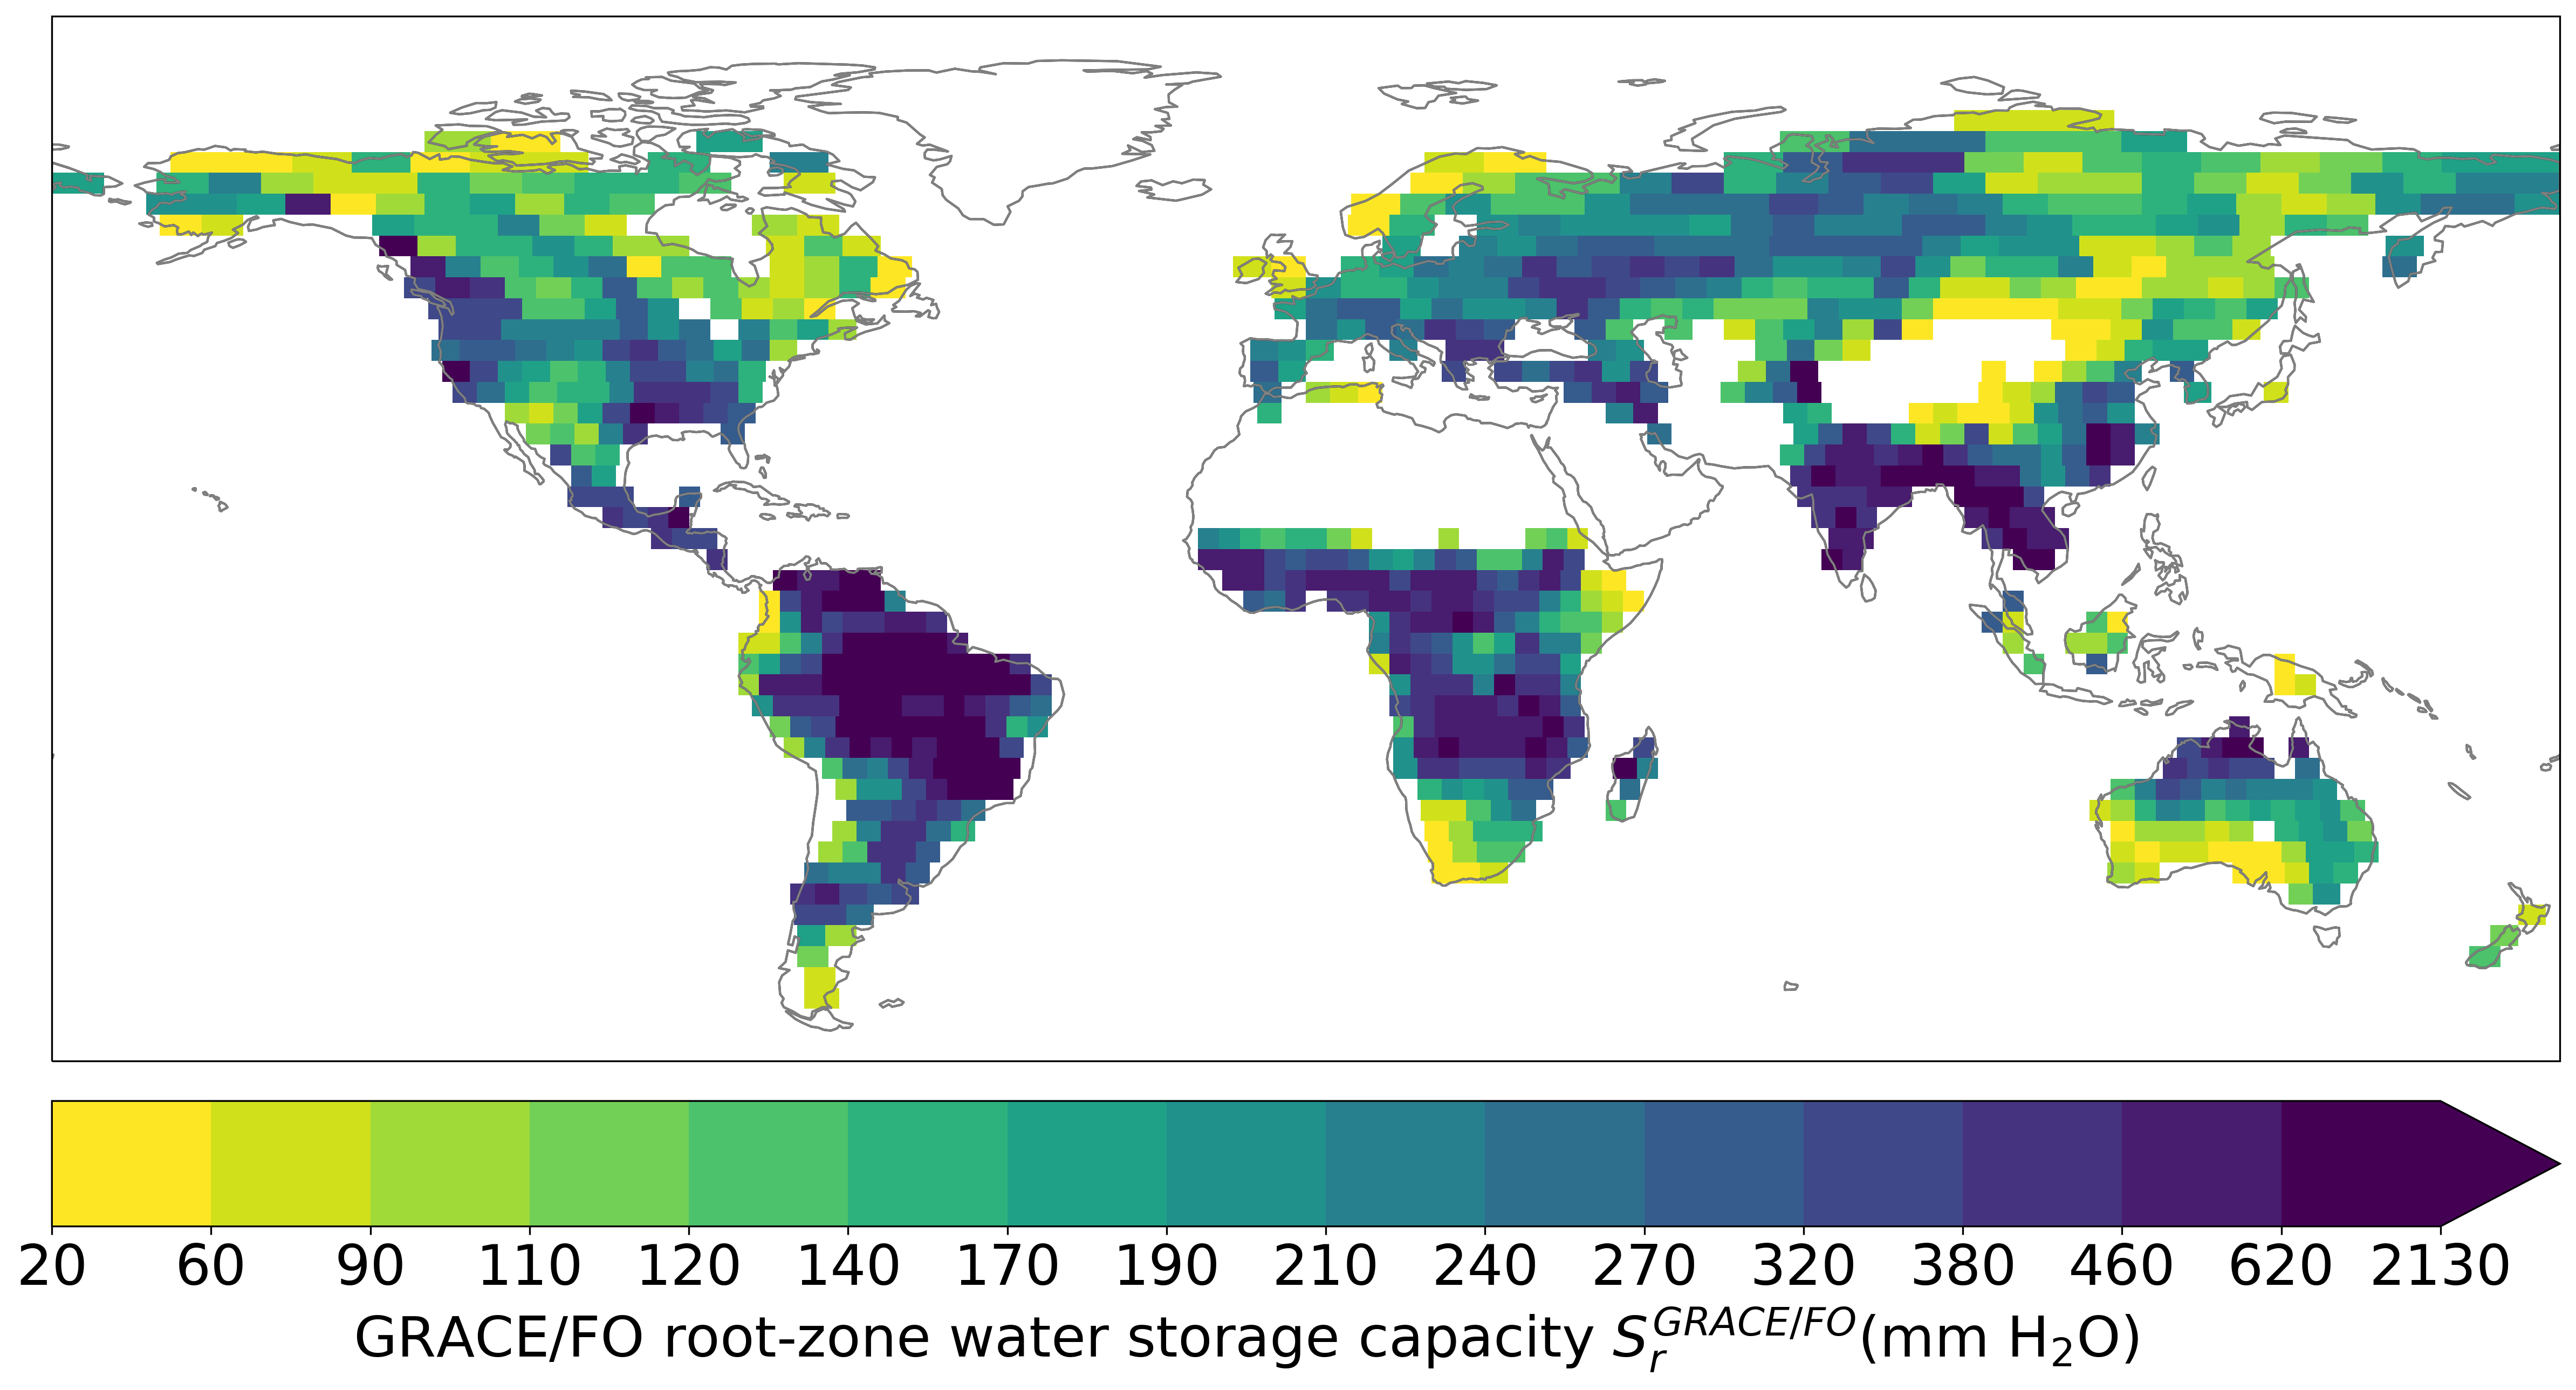

In [25]:
### plot maximum TWS drawdown map
n = 15
levels = np.zeros(n+1)
for i in range(n+1):
    #print(np.round(100/n*i))
    levels[i] = np.round(np.nanpercentile(dtwsmaxarr_max,100/n*i),-1)
    
mapping2(dtwsmaxarr_max, var_lon, var_lat,levels,label=r'GRACE/FO root-zone water storage capacity $S_{r}^{GRACE/FO}$(mm H$_{2}$O)', cmap='viridis_r',labelformat = '%2.0f',extend='max') #'YlGnBu'